In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from bnlp import NLTKTokenizer
from bs4 import BeautifulSoup
from bnlp import BengaliCorpus as corpus
import re
from bangla_stemmer.stemmer import stemmer

In [10]:
df_train = pd.read_csv('F:/Context_Aware_Data_Cleaning_Deep/EMONOBA/Dataset/emonoba_train.csv')
df_val = pd.read_csv('F:/Context_Aware_Data_Cleaning_Deep/EMONOBA/Dataset/emonoba_val.csv')

In [11]:
df_train

,ID,Data,Love,Joy,Surprise,Anger,Sadness,Fear,Topic,Domain,is_admin
0,5454,লকাল বাস ভালো এটা থেকে,0,0,0,0,1,0,Travel,Youtube,False
1,22549,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,0,0,0,0,1,0,Politics,Youtube,False
2,7033,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান (৬ ...,0,0,0,1,0,0,Personal,Facebook,False
3,21114,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,0,0,0,0,1,0,Education,Facebook,False
4,23683,সত্যিকার মানুষ তারাই ভাই,0,1,0,0,0,0,Personal,Youtube,False
...,...,...,...,...,...,...,...,...,...,...,...
18415,25861,সমস্যা নাই ইনশাআল্লাহ আমরা একদিন ক্রিকেট কে শা...,0,1,0,0,0,0,Sports,Youtube,False
18416,27263,খানকিরপুলা তর মাকে গিয়ে বল দেহো দিলা মনটা দিলা...,0,0,0,0,1,0,Music,Youtube,False
18417,13900,ভাই চেয়ার কই🙄,0,0,1,0,0,0,Education,Youtube,False
18418,1208,সবকয়টা তো একই গোয়ালের গাই,0,0,0,0,1,0,Education,Youtube,False


In [12]:
# Function to get the emotion with value 1 or NaN if all values are 0
def get_emotion(row):
    emotions = ['Love', 'Joy', 'Surprise', 'Anger', 'Sadness', 'Fear']
    nonzero_emotions = [emotion for emotion in emotions if row[emotion] == 1]
    return nonzero_emotions[0] if nonzero_emotions else np.nan

# Create a new column 'Emotion' based on the custom function
df_train['Label'] = df_train.apply(get_emotion, axis=1)

# Keep only 'Data' and 'Emotion' columns
df_train = df_train[['Data', 'Label']]

In [13]:
# Create a new column 'Emotion' based on the custom function
df_val['Label'] = df_val.apply(get_emotion, axis=1)

# Keep only 'Data' and 'Emotion' columns
df_test = df_val[['Data', 'Label']]

In [14]:
df_train.groupby("Label").describe()

Data                                                               
         count unique                                                top freq
Label                                                                        
Anger     3295   3289  সপ্তাহের চার দিনই নানা মিটিংয়ে হাজিরা দিতে হয়।...    2
Fear       162    162                          যদি গড় গ্রেড সি চলে আসে     1
Joy       6478   6450                                   অনেক ভালো লাগলো     5
Love      3786   3773                                মানুষ মানুষের জন্য     2
Sadness   3975   3974  কে সে? নিশ্চয়ই শয়তান জামাল! : না : তা হলে নিশ্...    2
Surprise   724    723  তাও বলছিস ভালোনা !!! কিন্তু তোরে তো ৪টা প্রশ্ন...    2

In [15]:
def rem_symbol_punct(text):
    pattern = re.compile('[!@#$%^&*()_+-={}\[\];:\'\"\|<>,.///?`~।]', flags=re.I)
    return pattern.sub(r'', text)


def remove_html_and_urls(text):
    # Remove HTML tags
    soup = BeautifulSoup(text, "html.parser")
    text_without_html = soup.get_text()

    # Remove URLs
    text_without_urls = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text_without_html)

    return text_without_urls


def remove_emojis(text):
    # Emoji patterns for different Unicode ranges
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F700-\U0001F77F"  # Alphanumeric Supplement
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbat symbols
        "\U000024C2-\U0001F251" 
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r'', text)


#remove noise
def Remove_text(text):
    text = rem_symbol_punct(text)
    text = remove_html_and_urls(text)
    text = remove_emojis(text)
    return text

In [16]:
df_train['Data'] = df_train['Data'].apply(Remove_text)
df_val['Data'] = df_val['Data'].apply(Remove_text)

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelBinarizer

In [18]:
df_train['Label'] = df_train['Label'].replace({0: 'Neutral', 1: 'Positive', 2: 'Negative'})
df_val['Label'] = df_val['Label'].replace({0: 'Neutral', 1: 'Positive', 2: 'Negative'})

In [19]:
count_vect = CountVectorizer() # for converting text into count-based vectors
tfidf_transformer = TfidfTransformer() # for converting text into tf-idf-based vectors
lb = LabelBinarizer() # object for making class-labels into binary numbers

In [20]:
df_train.columns

Index(['Data', 'Label'], dtype='object')

In [21]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df_train["classes_bin"] = lb_make.fit_transform(df_train["Label"])
df_val["classes_bin"] = lb_make.fit_transform(df_val["Label"])
df_train[["classes_bin", "Label"]].head(11)

,classes_bin,Label
0,4,Sadness
1,4,Sadness
2,0,Anger
3,4,Sadness
4,2,Joy
5,3,Love
6,2,Joy
7,0,Anger
8,0,Anger
9,2,Joy


In [22]:
df_train

,Data,Label,classes_bin
0,লকাল বাস ভালো এটা থেকে,Sadness,4
1,কত অভিজানই তো চলে কিন্তু ওয়াসার পানির অভিজান ক...,Sadness,4
2,বিয়ের মহল ছেড়ে তিনি বিস্রাম নিতে চলে যান ৬ ন...,Anger,0
3,চাচাজি তো কেবল মাকে ধর্ষণ করেছেন,Sadness,4
4,সত্যিকার মানুষ তারাই ভাই,Joy,2
...,...,...,...
18415,সমস্যা নাই ইনশাআল্লাহ আমরা একদিন ক্রিকেট কে শা...,Joy,2
18416,খানকিরপুলা তর মাকে গিয়ে বল দেহো দিলা মনটা দিলানা,Sadness,4
18417,ভাই চেয়ার কই,Surprise,5
18418,সবকয়টা তো একই গোয়ালের গাই,Sadness,4


In [23]:
df_train.isnull()

,Data,Label,classes_bin
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
18415,False,False,False
18416,False,False,False
18417,False,False,False
18418,False,False,False


In [24]:
df_train.dropna(inplace=True)

In [25]:
text = df_train['Data'].values.tolist()

In [26]:
df_train.groupby("Label").describe()

classes_bin                                   
               count mean  std  min  25%  50%  75%  max
Label                                                  
Anger         3295.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
Fear           162.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
Joy           6478.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0
Love          3786.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0
Sadness       3975.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0
Surprise       724.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0

In [27]:
df_train["Label"].value_counts()

Joy         6478
Sadness     3975
Love        3786
Anger       3295
Surprise     724
Fear         162
Name: Label, dtype: int64

In [28]:
df_train['Data'] = df_train['Data'].astype(str)
df_val['Data'] = df_val['Data'].astype(str)

In [29]:
train_text = df_train["Data"]

In [30]:
test_text= df_val["Data"]

In [31]:
train_counts = count_vect.fit_transform(train_text) # converting docs into vectors
train_tfidf  = train_counts 
train_tfidf = tfidf_transformer.fit_transform(train_counts) # converting transformed vectors into tf-idf vectors
train_tfidf.shape

(18420, 4090)

In [32]:
test_counts = count_vect.transform(test_text) # converting docs into vectors
test_tfidf  = test_counts 
test_tfidf = tfidf_transformer.transform(test_counts) # converting transformed vectors into tf-idf vectors
test_tfidf.shape

(2047, 4090)

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train = train_tfidf
X_test = test_tfidf

y_train = df_train['classes_bin']
y_test = df_val["classes_bin"]

In [35]:
Y_pre = df_train['Label']
target_names = list(set(Y_pre))

In [36]:
target_names

['Sadness', 'Love', 'Fear', 'Joy', 'Surprise', 'Anger']

In [37]:
X_train

<18420x4090 sparse matrix of type '<class 'numpy.float64'>'
	with 98979 stored elements in Compressed Sparse Row format>

In [38]:
y_train

0        4
1        4
2        0
3        4
4        2
        ..
18415    2
18416    4
18417    5
18418    4
18419    0
Name: classes_bin, Length: 18420, dtype: int32

In [39]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV 

In [40]:
import seaborn as sn

# Naive Bayes

In [41]:
from sklearn.naive_bayes import MultinomialNB

Test set accuracy 0.46995603321934537
              precision    recall  f1-score   support

     Sadness       0.52      0.17      0.25       362
        Love       0.00      0.00      0.00        20
        Fear       0.44      0.87      0.58       743
         Joy       0.60      0.16      0.26       414
    Surprise       0.55      0.44      0.49       429
       Anger       0.00      0.00      0.00        79

    accuracy                           0.47      2047
   macro avg       0.35      0.27      0.26      2047
weighted avg       0.49      0.47      0.41      2047



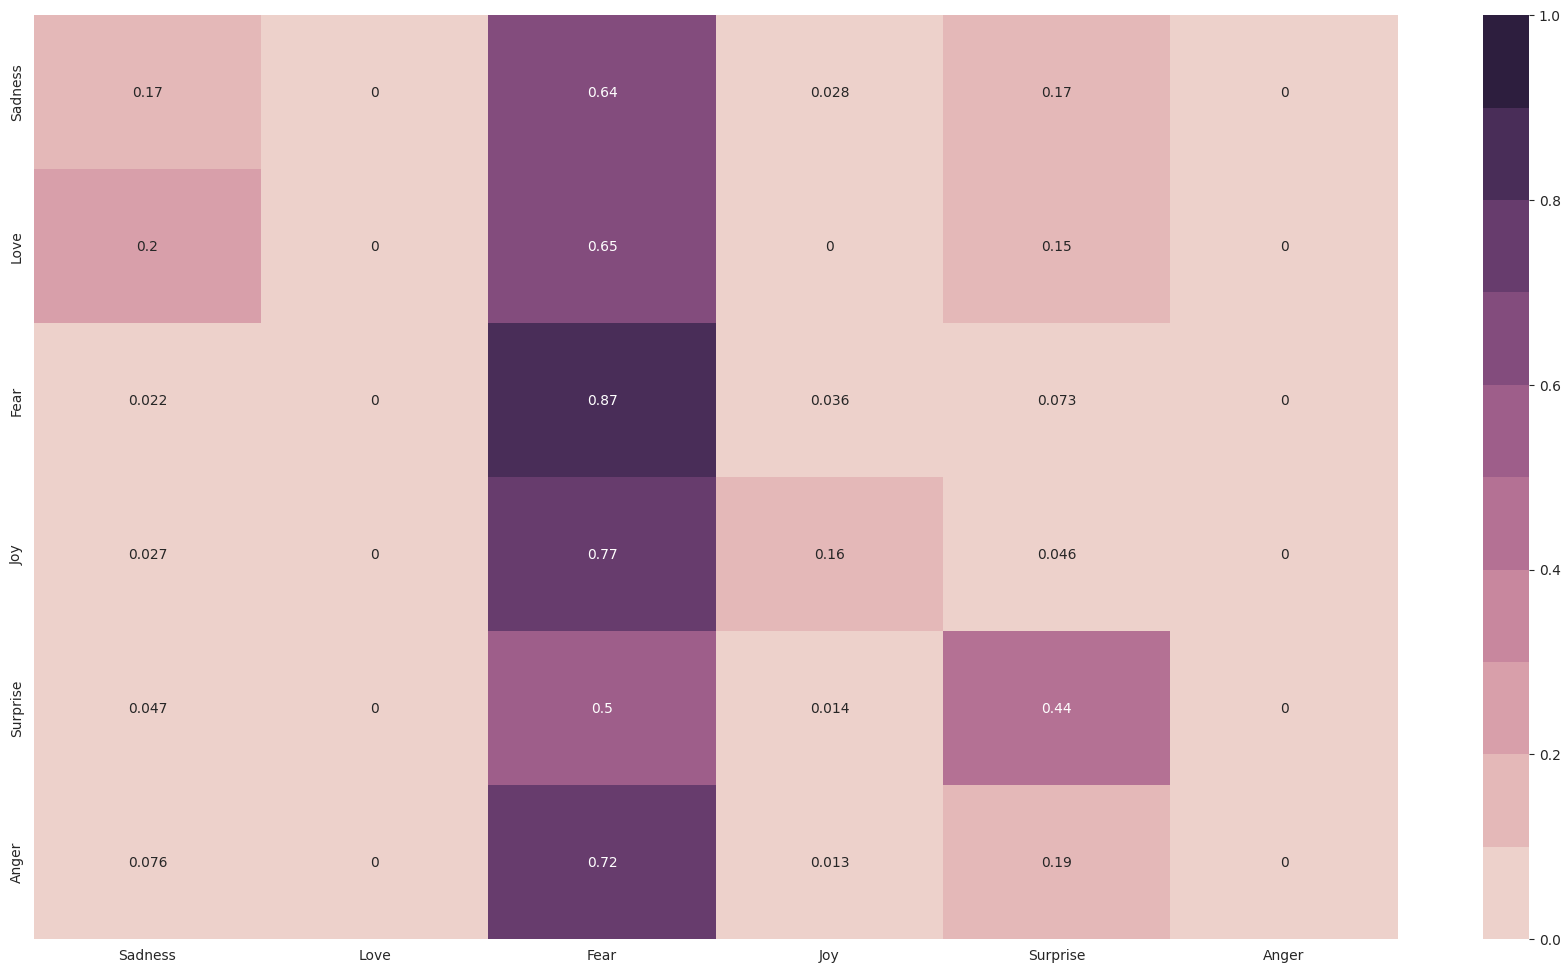

In [42]:
NBclassifer = MultinomialNB()
NBclassifer.fit(X_train, y_train)
y_pred = NBclassifer.predict(X_test)
print('Test set accuracy %s' % accuracy_score(y_test, y_pred))
cr = classification_report(y_test, y_pred, target_names=target_names)
print(cr)


# ------------------------------------------------------------------------------ #

cm = confusion_matrix(y_test, y_pred)
cm = (cm.T / cm.astype(float).sum(axis=1)).T

df_cm = pd.DataFrame(cm, range(len(target_names)), range(len(target_names)))
with sn.axes_style("white"):
    plt.figure(figsize = (22,12))
    ax = sn.heatmap(df_cm, annot=True, xticklabels=target_names, yticklabels=target_names, vmax=1,  cmap=sn.cubehelix_palette(10))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    fig = ax.get_figure()
  

In [43]:
NBclassifer.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}

# Support Vector Machine

In [44]:
from sklearn.svm import SVC


Test set accuracy 0.4963361016121153
              precision    recall  f1-score   support

     Sadness       0.45      0.33      0.38       362
        Love       0.00      0.00      0.00        20
        Fear       0.49      0.73      0.59       743
         Joy       0.52      0.27      0.36       414
    Surprise       0.54      0.55      0.55       429
       Anger       0.50      0.01      0.02        79

    accuracy                           0.50      2047
   macro avg       0.42      0.32      0.32      2047
weighted avg       0.49      0.50      0.47      2047



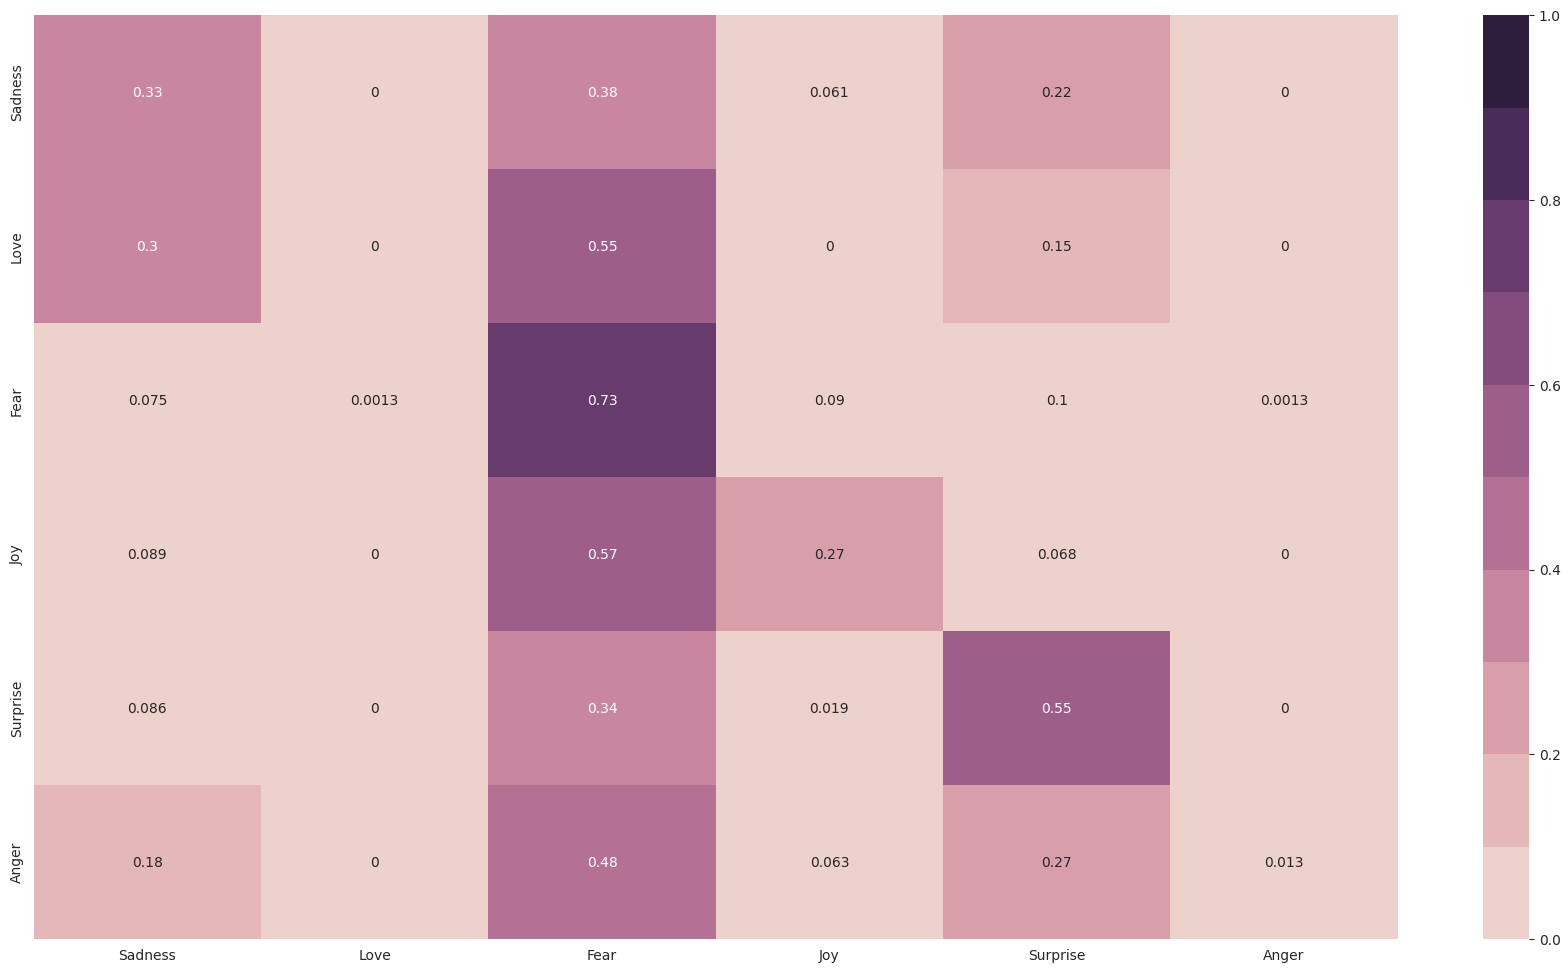

In [45]:
SVMclassifer = SVC()
SVMclassifer.fit(X_train, y_train)
y_pred = SVMclassifer.predict(X_test)
print('Test set accuracy %s' % accuracy_score(y_test, y_pred))
cr = classification_report(y_test, y_pred, target_names=target_names)
print(cr)

# ------------------------------------------------------------------------------ #

cm = confusion_matrix(y_test, y_pred)
cm = (cm.T / cm.astype(float).sum(axis=1)).T

df_cm = pd.DataFrame(cm, range(len(target_names)), range(len(target_names)))
with sn.axes_style("white"):
    plt.figure(figsize = (22,12))
    ax = sn.heatmap(df_cm, annot=True, xticklabels=target_names, yticklabels=target_names, vmax=1,  cmap=sn.cubehelix_palette(10))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    fig = ax.get_figure()

# XGBoost

In [46]:
from xgboost import XGBClassifier

Test set accuracy 0.4694675134342941
              precision    recall  f1-score   support

     Sadness       0.42      0.27      0.33       362
        Love       0.00      0.00      0.00        20
        Fear       0.46      0.73      0.56       743
         Joy       0.50      0.29      0.37       414
    Surprise       0.52      0.46      0.49       429
       Anger       0.17      0.03      0.04        79

    accuracy                           0.47      2047
   macro avg       0.35      0.30      0.30      2047
weighted avg       0.46      0.47      0.44      2047



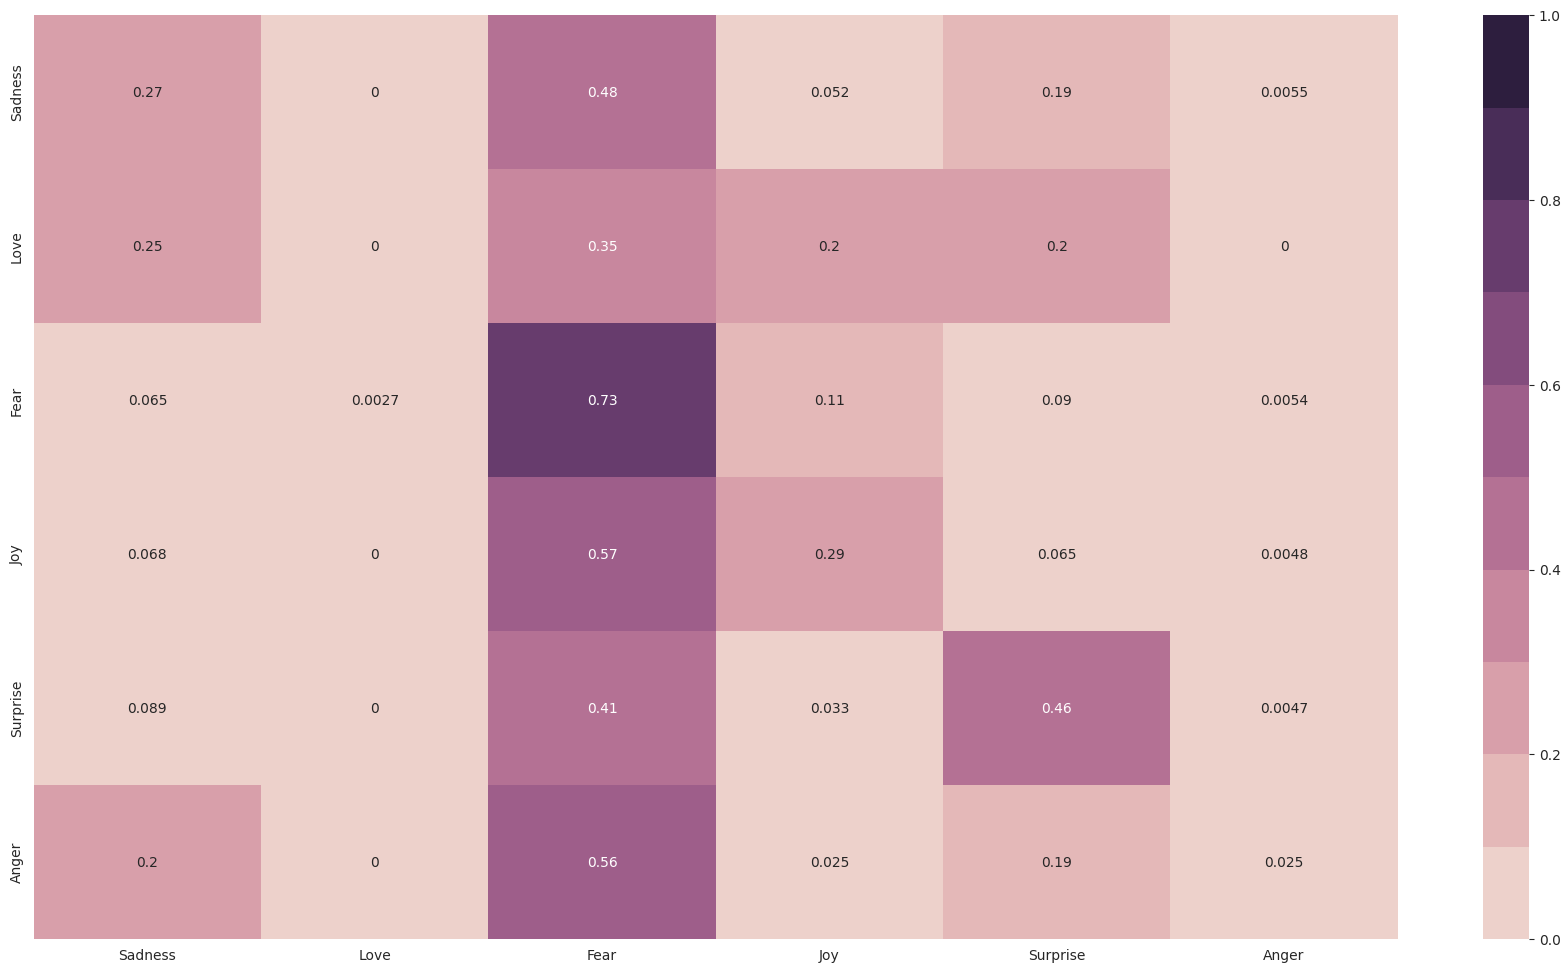

In [47]:
XGBclassifer = XGBClassifier()
XGBclassifer.fit(X_train, y_train)
y_pred = XGBclassifer.predict(X_test)
print('Test set accuracy %s' % accuracy_score(y_test, y_pred))
cr = classification_report(y_test, y_pred, target_names=target_names)
print(cr)

# ------------------------------------------------------------------------------ #

cm = confusion_matrix(y_test, y_pred)
cm = (cm.T / cm.astype(float).sum(axis=1)).T

df_cm = pd.DataFrame(cm, range(len(target_names)), range(len(target_names)))
with sn.axes_style("white"):
    plt.figure(figsize = (22,12))
    ax = sn.heatmap(df_cm, annot=True, xticklabels=target_names, yticklabels=target_names, vmax=1,  cmap=sn.cubehelix_palette(10))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    fig = ax.get_figure()


# Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

Test set accuracy 0.4572545188080117
              precision    recall  f1-score   support

     Sadness       0.41      0.28      0.33       362
        Love       0.00      0.00      0.00        20
        Fear       0.46      0.67      0.55       743
         Joy       0.43      0.26      0.32       414
    Surprise       0.49      0.51      0.50       429
       Anger       0.36      0.06      0.11        79

    accuracy                           0.46      2047
   macro avg       0.36      0.30      0.30      2047
weighted avg       0.44      0.46      0.43      2047



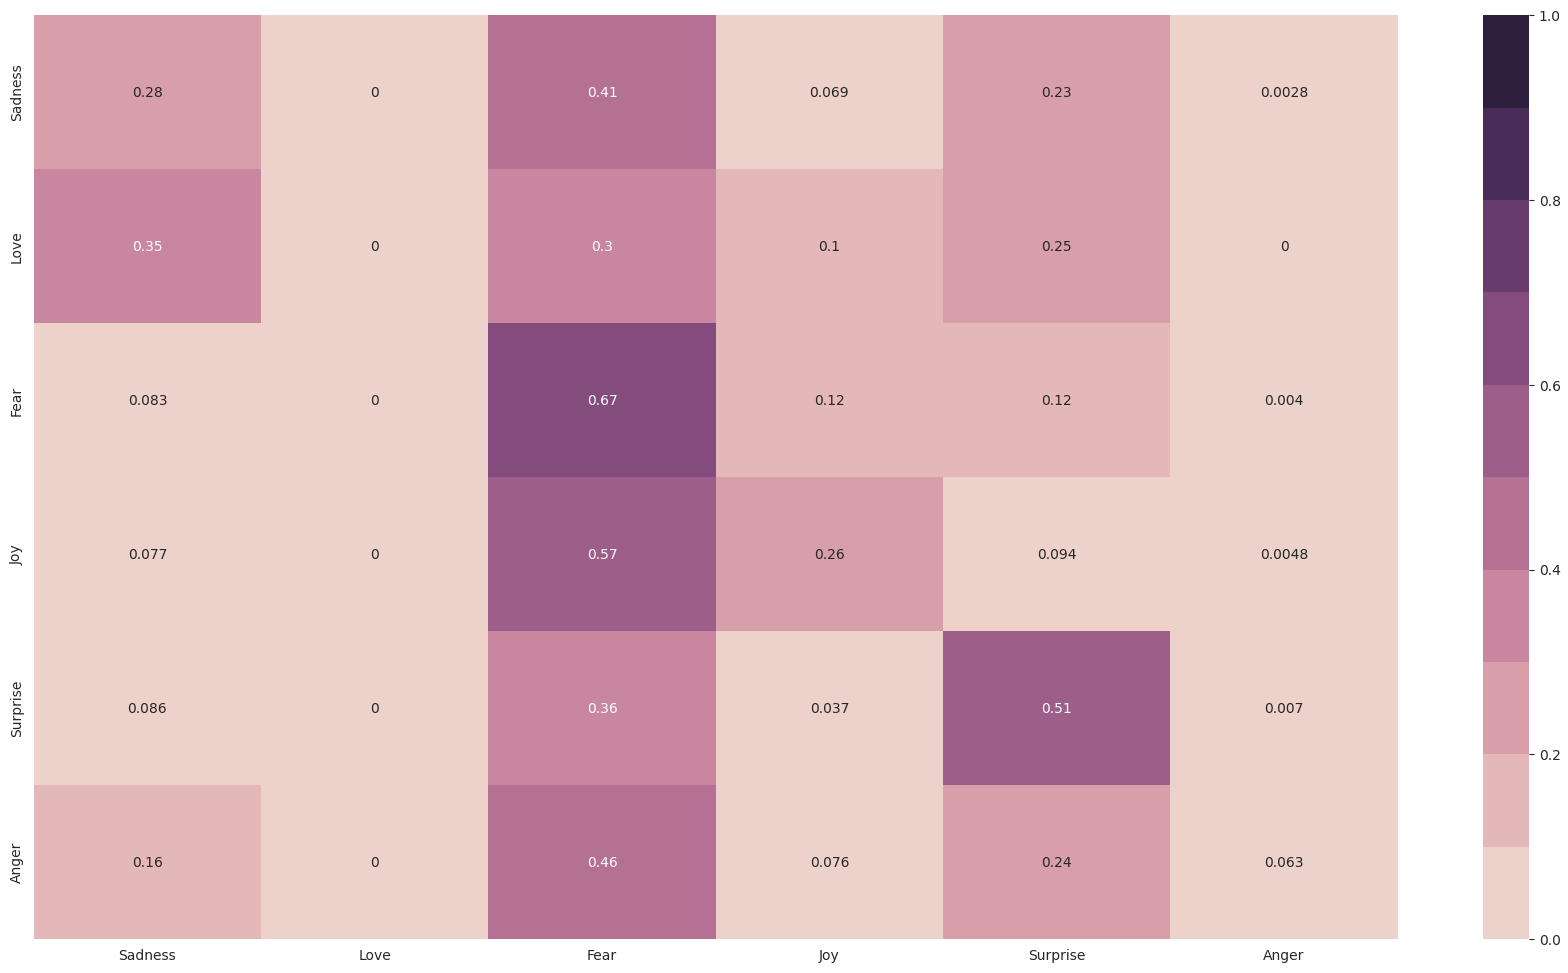

In [49]:
RFclassifer = RandomForestClassifier()
shapas = RFclassifer.fit(X_train, y_train)
y_pred = RFclassifer.predict(X_test)
print('Test set accuracy %s' % accuracy_score(y_test, y_pred))
cr = classification_report(y_test, y_pred, target_names=target_names)
print(cr)

# ------------------------------------------------------------------------------ #

cm = confusion_matrix(y_test, y_pred)
cm = (cm.T / cm.astype(float).sum(axis=1)).T

df_cm = pd.DataFrame(cm, range(len(target_names)), range(len(target_names)))
with sn.axes_style("white"):
    plt.figure(figsize = (22,12))
    ax = sn.heatmap(df_cm, annot=True, xticklabels=target_names, yticklabels=target_names, vmax=1,  cmap=sn.cubehelix_palette(10))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    fig = ax.get_figure()
  